<h2>Time-Height Cross-Sections</h2>

This example demonstrates how to take 3-D WRF-ARW output from multiple times (in this case, using data from separate files), compute the area average of a field over a specified lat/lon range at each time, and create a time-height cross-section from the resulting data.

The example below plots the area-averaged microphysical parameterization heating rate (between 1000-100 hPa) over a small domain centered on the northern Florida peninsula from nine times (every 3 hr from 0000 UTC 7 October 2016 to 0000 UTC 8 October 2016), using data obtained from the Assignment 1 tutorial case.

More information on how to use wrf-python is available at https://wrf-python.readthedocs.io/en/main/basic_usage.html.

<hr>

We start by importing the needed modules. These are drawn from four packages - netCDF4, matplotlib, numpy, and wrf (short for wrf-python). We do not need to load cartopy because there is no mapping involved. Note that wrf-python treats data as xarrays, which makes xarray functions (such as the sel function we use to subset data) available to us without loading xarray ourselves.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import (NullFormatter, ScalarFormatter)
import matplotlib.dates as mdates
from netCDF4 import Dataset
from wrf import to_np, getvar, ll_to_xy, ALL_TIMES

Open all of the desired wrfout files and store the resulting Dataset entities to a variable.

In [35]:
filelist = [Dataset("wrfout_d01_2016-10-07_00:00:00"),
            Dataset("wrfout_d01_2016-10-07_03:00:00"),
            Dataset("wrfout_d01_2016-10-07_06:00:00"),
            Dataset("wrfout_d01_2016-10-07_09:00:00"),
            Dataset("wrfout_d01_2016-10-07_12:00:00"),
            Dataset("wrfout_d01_2016-10-07_15:00:00"),
            Dataset("wrfout_d01_2016-10-07_18:00:00"),
            Dataset("wrfout_d01_2016-10-07_21:00:00"),
            Dataset("wrfout_d01_2016-10-08_00:00:00")]

Extract the 3-D model pressure and H_DIABATIC variable at all times. The first field, a wrf-python derived variable, is in hPa by default. The second field, a WRF-ARW output variable, is in K s-1 by default per the wrfout_d01 file's metadata (which you can obtain using ncdump, among other tools).

The timeidx=ALL_TIMES option indicates to wrf-python to get data for all of the times included in the filelist variable. It relies on the ALL_TIMES import in the first code block above. The method="cat" option indicates to wrf-python to concatenate the data together - here, along the time axis given that the different wrfout files vary only in the time dimension.

In [36]:
p = getvar(filelist, "pressure", timeidx=ALL_TIMES, method="cat")
hdiab = getvar(filelist, "H_DIABATIC", timeidx=ALL_TIMES, method="cat")

Specify the latitude and longitude ranges over which to compute the area average, then use the wrf-python ll_to_xy helper function to convert these to x/y points. We call this helper function because the model variables have dimensions south_north and west_east, which refer to x/y points rather than to lat/lon location, and these variables are what we will later use to subset the data for the area average.

The pair lat1,lon1 refers to the southwestern corner of the domain, whereas the pair lat2,lon2 refers to the northeastern corner of the domain. The resulting x/y values provide us with the bounds for the area average to come.

In [37]:
lat1 = 26.0
lat2 = 34.0
lon1 = -87.0
lon2 = -76.0

x1, y1 = to_np(ll_to_xy(filelist, lat1, lon1))
x2, y2 = to_np(ll_to_xy(filelist, lat2, lon2))

Next, we subset the data from the full domain to just that associated with our area average. We use the xarray helper function sel() to do so. Note how we save the subset data to a new variable; this allows us to continue to work with the full dataset without reloading it if we wish to do so. We pass the subsetting bounds to each dimension (south_north and west_east) as slices, which are sequences of numbers from the first entry to the second entry.

In [38]:
p_sub = p.sel(south_north=slice(y1,y2), west_east=slice(x1,x2))
hdiab_sub = hdiab.sel(south_north=slice(y1,y2), west_east=slice(x1,x2))

Printing the resulting p_sub variable displays its data and associated dimensions. Note that south_north is now 33, west_east is now 39, and the values of the coordinates XLONG and XLAT range from 26-34°N and 87-76°W as specified.

In [39]:
print(p_sub)

<xarray.DataArray 'pressure' (Time: 9, bottom_top: 44, south_north: 33, west_east: 39)>
array([[[[1006.71515 , 1006.617   , 1006.4682  , ..., 1003.2409  ,
          1004.0451  , 1004.95074 ],
         [1006.9075  , 1006.7899  , 1006.65546 , ..., 1003.3486  ,
          1004.17035 , 1005.0451  ],
         [1007.09326 , 1007.0236  , 1006.8778  , ..., 1003.5392  ,
          1004.3521  , 1005.2419  ],
         ...,
         [ 992.7927  ,  992.8569  ,  992.57294 , ..., 1013.3047  ,
          1013.39075 , 1013.46985 ],
         [ 992.65076 ,  989.6951  ,  992.13257 , ..., 1013.3438  ,
          1013.3876  , 1013.7662  ],
         [ 994.11255 ,  988.0949  ,  988.172   , ..., 1013.63873 ,
          1013.64856 , 1013.84326 ]],

        [[1000.4359  , 1000.33026 , 1000.1494  , ...,  996.9668  ,
           997.7616  ,  998.64874 ],
         [1000.624   , 1000.4892  , 1000.33795 , ...,  997.0732  ,
           997.87427 ,  998.7581  ],
         [1000.7743  , 1000.70544 , 1000.5331  , ...,  997.2645 

The area-average for each variable can be obtained using xarray's mean attribute function. For the microphysical parameterization heating rate, we only want the area average to be along the south_north and west_east dimensions. For pressure, however, we want the area-average to be along the south_north, west_east, and bottom_top dimensions. The latter relies on the assumption that the model's vertical surfaces are at nearly constant altitudes with time. This allows us to pass in a 1-D array of pressure levels for the y-axis when we plot the data. Caveat emptor!

The resulting hdiab_mean variable has two varying dimensions: Time (representing the time axis) and bottom_top (representing the model's vertical dimension). The latter has no values ascribed to it, however. The resulting p_mean variable has a single varying dimension: bottom_top.

In [40]:
hdiab_mean = hdiab_sub.mean(dim=['south_north', 'west_east'])
p_mean = p_sub.mean(dim=['Time','south_north', 'west_east'])

The remainder of the plot-generation code is contained in a single code block below. This is due to a Python quirk; a figure is generated before we add any data to it if we try to break the code up into separate code blocks. Please see the comment blocks below to interpret the code.

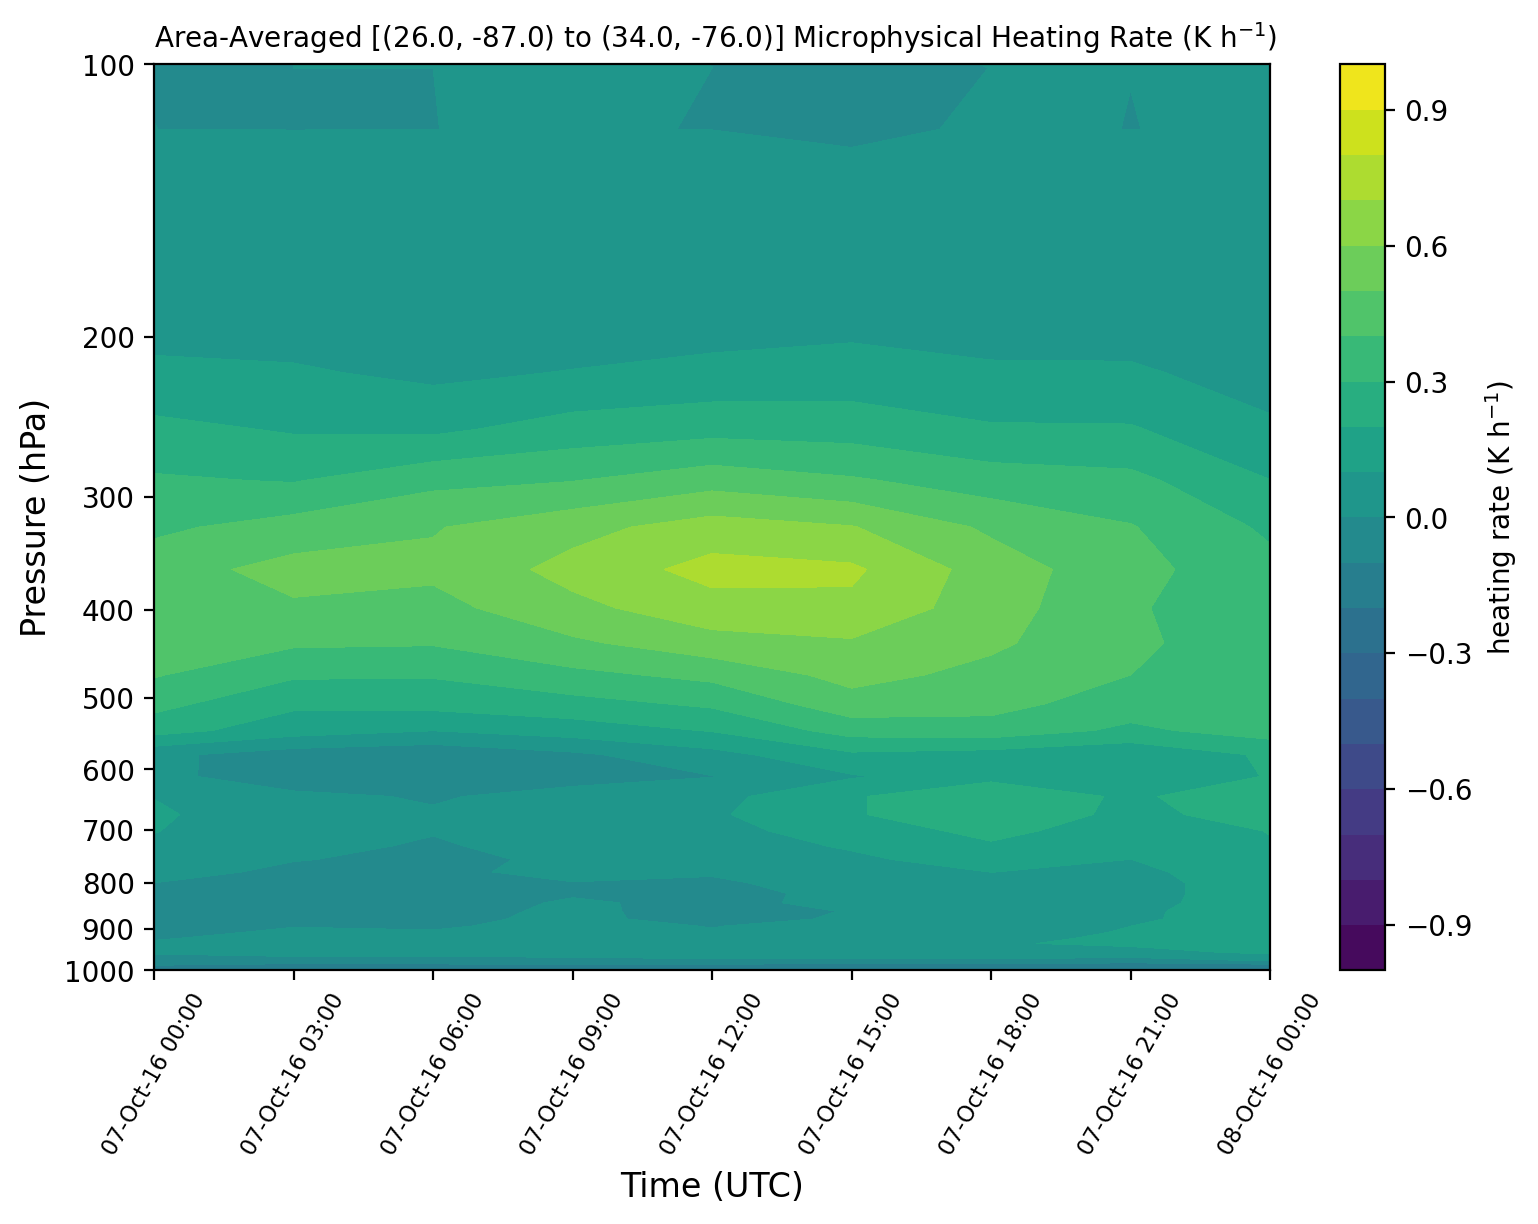

In [41]:
# Create the figure instance (9" wide by 6" tall,
# 200 dots per inch), then establish the figure's axes.
fig = plt.figure(figsize=(9,6), dpi=200.)
ax = plt.axes()

# We plot the area-averaged microphysical parameterization
# heating rate as a shaded field. We pass in the times from
# that variable (which have a unique date/time structure) as
# the x-axis values and the time-averaged pressure variable
# as the y-axis values. Note that we have to transpose the
# display variable so that time corresponds to the x-axis
# rather than the y-axis (which is what matplotlib thinks
# it corresponds to given how the data are arranged in the
# array), and likewise for the vertical dimension. We also
# multiply the result by 3600 to convert from K s-1 to K
# h-1 since the latter are more intuitive units. We set
# shading levels from -1 to +1 K h-1 by 0.1 K h-1, shade
# the field using the viridis colormap, then add a labeled
# colorbar on the side.
hdiab_contours = plt.contourf(hdiab_mean.Time, p_mean, 
                             hdiab_mean.transpose()*3600.,
                             levels=np.arange(-1.,1.1,0.1),
                             cmap=get_cmap("viridis"))
plt.colorbar(hdiab_contours, ax=ax, pad=.05, label="heating rate (K h$^{-1}$)")

# This set of code structures our x-axis. We first set
# the tick label size to 8pt font. We then set the
# date/time format of the tick labels to Day-Month-Year
# Hour:00. Finally, we rotate the tick labels to be
# mostly vertical rather than horizontal.
ax.tick_params(axis='x', labelsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%y %H:00"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%b-%y %H:00"))
plt.xticks(rotation=60)

# If you find that too many x-axis tick labels are
# being drawn by the code above, you can limit which
# ones are drawn by specifying the tick labels, e.g.,
# ax.set_xticks(wspd_mean.Time[::2])
# sets the x-axis tick labels to be the values of the
# Time coordinate on wspd_mean, but only every 2nd
# value from the beginning to the end of the data.
# This doesn't change what data are plotted, just
# what ticks and tick labels are plotted.

# This set of code structures our y-axis ticks and their labels.
# We first set the y-axis to be logarithmic rather than linear.
# Next, we set how the logarithmic axis labels should be structured,
# using scalars rather than powers of 10. Once we have
# done that, we define ten y-axis ticks from 100 to 1000 hPa.
# Finally, we set the y-axis limits - in this case, 1000-100 hPa,
# which ensures the y-axis decreases rather than increases upward.
ax.set_yscale('symlog')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticks(np.linspace(100, 1000, 10))
ax.set_ylim(1000., 100.)

# Set the x-axis and y-axis labels.
ax.set_xlabel("Time (UTC)", fontsize=12)
ax.set_ylabel("Pressure (hPa)", fontsize=12)

# Title the plot and then display it.
plt.title("Area-Averaged [(" + str(lat1) + ", " + str(lon1) + ") to (" + str(lat2) + ", " + str(lon2) + ")] Microphysical Heating Rate (K h$^{-1}$)", loc="left", fontsize=10)
plt.show()